## Detecting Myocardial Infarction

The method and model are based on this article : https://arxiv.org/abs/1805.00794

### Let's start with some imports

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
%config IPCompleter.greedy=True

### Fetching data

In [3]:
df_mitbih_train = pd.read_csv('../input/heartbeat/mitbih_train.csv', header=None)
df_mitbih_test = pd.read_csv('../input/heartbeat/mitbih_test.csv', header=None)
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)

df_ptbdb_normal = pd.read_csv('../input/heartbeat/ptbdb_normal.csv', header=None)
df_ptbdb_abnormal = pd.read_csv('../input/heartbeat/ptbdb_abnormal.csv', header=None)
df_ptbdb = pd.concat([df_ptbdb_normal, df_ptbdb_abnormal], axis=0)

print(df_mitbih.info())
print(df_ptbdb.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14552 entries, 0 to 10505
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 21.0 MB
None


The MITBIH dataset is constituted of 109446 beats, labeled with 5 different classes : 

'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4

    N : Non-ecotic beats (normal beat) 

    S : Supraventricular ectopic beats 

    V : Ventricular ectopic beats

    F : Fusion Beats 

    Q : Unknown Beats

The PTBHB dataset is constituted of 14552 beats, labeled with two different classes : 

    '0' for normal beat
    '1' for abnormal beat (Myocardial infarction)

All the beats are recorded with 187 points. The shorter beats are padded with zeros to reach 187.

## Visualization of the dataset

In [4]:
# ptbdb
M_ptbdb = df_ptbdb.values
X_ptbdb = M_ptbdb[:,:-1]
y_ptbdb = M_ptbdb[:,-1]

# mitbih
M_mitbih = df_mitbih.values
X_mitbih = M_mitbih[:,:-1]
y_mitbih = M_mitbih[:,-1]

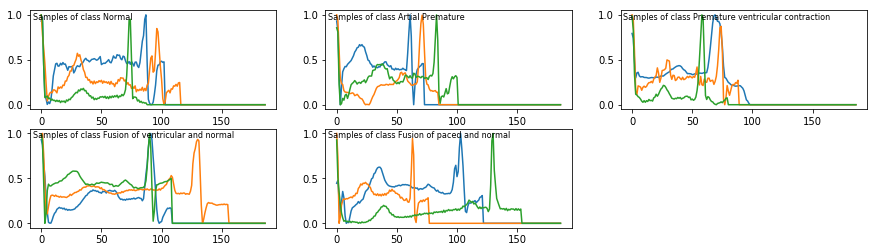

In [5]:
classes={0:"Normal",
         1:"Artial Premature",
         2:"Premature ventricular contraction",
         3:"Fusion of ventricular and normal",
         4:"Fusion of paced and normal"}
plt.figure(figsize=(15,4))
for i in range(0,5):
    plt.subplot(2,3,i + 1)
    all_samples_indexes = np.where(y_mitbih == i)[0]
    rand_samples_indexes = np.random.randint(0, len(all_samples_indexes), 3)
    rand_samples = X_mitbih[rand_samples_indexes]
    plt.plot(rand_samples.transpose())
    plt.title("Samples of class " + classes[i], loc='left', fontdict={'fontsize':8}, x=0.01, y=0.85)


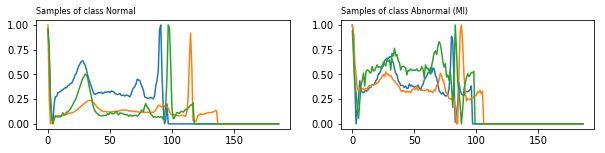

In [6]:
classes={0:"Normal", 1:"Abnormal (MI)"}
plt.figure(figsize=(10,2))
for i in range(0,2):
    plt.subplot(1,2,i + 1)
    all_samples_indexes = np.where(y_ptbdb == i)[0]
    rand_samples_indexes = np.random.randint(0, len(all_samples_indexes), 3)
    rand_samples = X_ptbdb[rand_samples_indexes]
    plt.plot(rand_samples.transpose())
    plt.title("Samples of class " + classes[i], loc="left", fontdict={'fontsize':8})

In [7]:
repartition = df_mitbih[187].astype(int).value_counts()
print(repartition)

0    90589
4     8039
2     7236
1     2779
3      803
Name: 187, dtype: int64


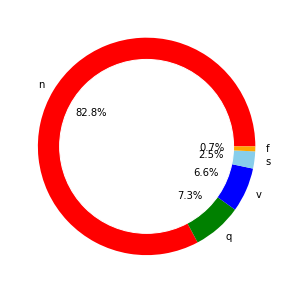

In [8]:
plt.figure(figsize=(5,5))
circle=plt.Circle( (0,0), 0.8, color='white')
plt.pie(repartition, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(circle)
plt.show()

The data repartition is very imbalanced : 83% of the data are normal beats.

## Model

In [9]:
from tensorflow.keras.layers import Input, Conv1D, MaxPool1D, Activation, Add, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

In [10]:
input_shape = (187, 1)

def make_model(final_layer_size=5):
    I = Input(input_shape)
    C = Conv1D(filters=32, kernel_size=5)(I)

    C11 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(C)
    C12 = Conv1D(filters=32, kernel_size=5, padding='same')(C11)
    A11 = Add()([C, C12])
    R11 = Activation(activation='relu')(A11)
    M11 = MaxPool1D(pool_size=5, strides=2)(R11)

    C21 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(M11)
    C22 = Conv1D(filters=32, kernel_size=5, padding='same')(C21)
    A21 = Add()([M11, C22])
    R21 = Activation(activation='relu')(A21)
    M21 = MaxPool1D(pool_size=5, strides=2)(R21)

    C31 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(M21)
    C32 = Conv1D(filters=32, kernel_size=5, padding='same')(C31)
    A31 = Add()([M21, C32])
    R31 = Activation(activation='relu')(A31)
    M31 = MaxPool1D(pool_size=5, strides=2)(R31)

    C41 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(M31)
    C42 = Conv1D(filters=32, kernel_size=5, padding='same')(C41)
    A41 = Add()([M31, C42])
    R41 = Activation(activation='relu')(A41)
    M41 = MaxPool1D(pool_size=5, strides=2)(R41)

    C51 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(M41)
    C52 = Conv1D(filters=32, kernel_size=5, padding='same')(C51)
    A51 = Add()([M41, C52])
    R51 = Activation(activation='relu')(A51)
    M51 = MaxPool1D(pool_size=5, strides=2)(R51)

    F1 = Flatten()(M51)
    D1 = Dense(32)(F1)
    R1 = Activation(activation='relu')(D1)
    D2 = Dense(32)(R1)
    D3 = Dense(final_layer_size)(D2)

    O = Activation(activation='softmax')(D3)

    return Model(inputs=I, outputs=O)

"For training the networks, we used Adam optimization method with the learning rate, beta-1, and beta-2 of 0.001, 0.9, and 0.999, respectively. Learning rate is decayed exponentially with the decay factor of 0.75 every 10000 iterations."

In [11]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.001, decay_steps=10000, decay_rate=0.75)
adam = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, amsgrad=False)

### Detecting MI with ptbdb dataset only

In [12]:
n_classes = len(np.unique(y_ptbdb))
model_ptbdb = make_model(n_classes)
model_ptbdb.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 183, 32)      192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 183, 32)      5152        conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 183, 32)      5152        conv1d_1[0][0]                   
______________________________________________________________________________________________

In [13]:
X_train_ptbdb, X_test_ptbdb, y_train_ptbdb, y_test_ptbdb = train_test_split(X_ptbdb, y_ptbdb, test_size=0.15)

In [14]:
model_ptbdb.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
history = model_ptbdb.fit(np.expand_dims(X_train_ptbdb, axis=2), 
                          y_train_ptbdb, 
                          validation_split=0.15,
                          epochs=30,
                          batch_size=256,
                          verbose=0)

In [16]:
def plot_learning(history):
    plt.subplot(211)
    plt.plot(history.history['accuracy'])
    plt.legend(["accuracy"])
    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'], label = "val_loss")
    plt.legend(["loss", "val_loss"])
    plt.show()
    

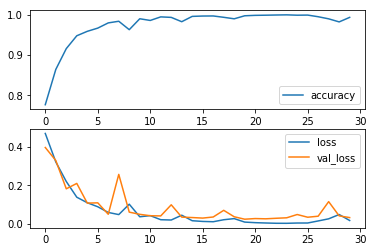

In [17]:
plot_learning(history)

The loss converges at around 15 epochs.

Let's try on the testing set.

In [18]:
unique, counts = np.unique(y_test_ptbdb, return_counts=True)
print(f"The testing set contains {counts[0]} normal recordings and {counts[1]} with myocardial infarction.\nLet's compute the confusion matrix.")

The testing set contains 614 normal recordings and 1569 with myocardial infarction.
Let's compute the confusion matrix.


In [19]:
results = model_ptbdb.evaluate(np.expand_dims(X_test_ptbdb, axis=2), y_test_ptbdb, batch_size=128)
print(f"The accuracy on the testing set is {np.round(results[1]*100,1)}%")

2183/2183 [==============================] - 0s 153us/sample - loss: 0.0333 - accuracy: 0.9908
The accuracy on the testing set is 99.1%


In [20]:
y_pred_ptbdb = model_ptbdb.predict(np.expand_dims(X_test_ptbdb, axis=2))
y_pred_ptbdb_bool = np.argmax(y_pred_ptbdb, axis=1)
print(classification_report(y_test_ptbdb, y_pred_ptbdb_bool))

confusion_matrix = tf.math.confusion_matrix(y_test_ptbdb, y_pred_ptbdb_bool)
print(f"Confusion matrix :\n {confusion_matrix}")

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       614
         1.0       1.00      0.99      0.99      1569

    accuracy                           0.99      2183
   macro avg       0.99      0.99      0.99      2183
weighted avg       0.99      0.99      0.99      2183

Confusion matrix :
 [[ 607    7]
 [  13 1556]]


In [21]:
print(f"{confusion_matrix[0][0]}/{counts[0]} MI were correctly classified")

print(f"{confusion_matrix[1][1]}/{counts[1]} normal beats were correctly classified")

print(f"{confusion_matrix[1][0]} beats were classified as MI")

print(f"{confusion_matrix[0][1]} MI were classified as normal")


607/614 MI were correctly classified
1556/1569 normal beats were correctly classified
13 beats were classified as MI
7 MI were classified as normal


The results for detecting MI by training directly with the ptbdb dataset are excellent : precision, recall, f1 and accuracy are all at around 0,99 on the testing set.

## Detecting MI with the mitbih dataset and transfert learning

The research article suggests a training on the mitbih dataset with 5 output classes to detect high level features.

Then, this model is frozen and followed by two dense layers of size 32 trained on the ptbdb dataset. Let's try to implement this.

### Training on mitbih

This dataset has 5 classes as outputs.

In [22]:
X_train_mitbih, X_test_mitbih, y_train_mitbih, y_test_mitbih = train_test_split(X_mitbih, y_mitbih, test_size=0.15)

In [23]:
n_classes_mitbih = len(np.unique(y_mitbih))
model_mitbih = make_model(n_classes_mitbih)
model_mitbih.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [24]:
history = model_mitbih.fit(np.expand_dims(X_train_mitbih, axis=2), 
                           y_train_mitbih, 
                           validation_split=0.15,
                           epochs=30,
                           batch_size=256,
                           verbose=0)

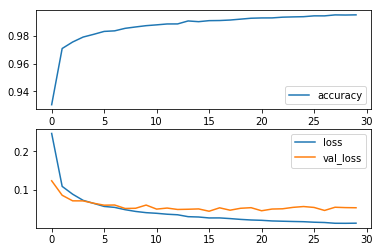

In [25]:
plot_learning(history)

The model converges at around 7-10 epochs on the validation set.

In [26]:
results = model_mitbih.evaluate(np.expand_dims(X_test_mitbih, axis=2), y_test_mitbih, batch_size=128)
print(f"The accuracy on the testing set is {np.round(results[1]*100,1)}%")

16417/16417 [==============================] - 3s 158us/sample - loss: 0.0626 - accuracy: 0.9853
The accuracy on the testing set is 98.5%


In [27]:
predictions = model_mitbih.predict(np.expand_dims(X_test_mitbih, axis=2))
confusion_matrix = tf.math.confusion_matrix(y_test_mitbih, np.argmax(predictions[:], axis=1))
print(confusion_matrix)

tf.Tensor(
[[13508    43    13     1     8]
 [   74   350     3     0     0]
 [   31     9  1051     5     3]
 [   19     1    14    89     0]
 [   15     2     0     0  1178]], shape=(5, 5), dtype=int32)


In [28]:
y_pred_mitbih = model_mitbih.predict(np.expand_dims(X_test_mitbih, axis=2))
y_pred_mitbih_bool = np.argmax(y_pred_mitbih, axis=1)
print(classification_report(y_test_mitbih, y_pred_mitbih_bool))

confusion_matrix = tf.math.confusion_matrix(y_test_mitbih, y_pred_mitbih_bool)
print(f"Confusion matrix :\n {confusion_matrix}")

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     13573
         1.0       0.86      0.82      0.84       427
         2.0       0.97      0.96      0.96      1099
         3.0       0.94      0.72      0.82       123
         4.0       0.99      0.99      0.99      1195

    accuracy                           0.99     16417
   macro avg       0.95      0.90      0.92     16417
weighted avg       0.99      0.99      0.99     16417

Confusion matrix :
 [[13508    43    13     1     8]
 [   74   350     3     0     0]
 [   31     9  1051     5     3]
 [   19     1    14    89     0]
 [   15     2     0     0  1178]]


The results for the classification with 5 classes are quite good although it struggles a bit for the classes 1 and 3 with a recall of 0.74-0.78 and an f1-score of 0.80-0.84.

### Transfer learning

Now, let's add the two dense layers with transfer learning.
This implies a bottleneck since the last layers will follow these sizes :

[...] --> 32 --> **5** --> 32 --> 32 --> 2

In [29]:
D1 = Dense(32)(model_mitbih.output)
D2 = Dense(32)(D1)
O = Dense(2, activation='softmax')(D2)
model = Model(inputs=model_mitbih.input, outputs=O)

for layer in model.layers[:-3]:
    layer.trainable = False

for layer in model.layers[-3:]:
    layer.trainable = True
    
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
history = model.fit(np.expand_dims(X_train_ptbdb, axis=2), 
                    y_train_ptbdb, 
                    validation_split=0.15,
                    epochs=5,
                    batch_size=128,
                    verbose=0)

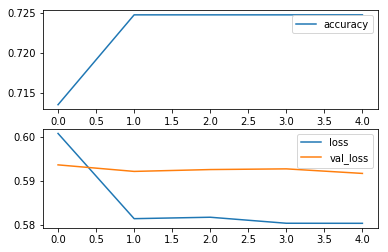

In [31]:
plot_learning(history)

The results seem to be drastically worse than without transfer learning. The validate accuracy is constant after one epoch only. I'm not sure how they reached 95,9% accuracy on the article. The model designed above seems correct, with only the last layers set as trainable, as we can see below.

In [32]:
print("Trainability of the layers \n")
for layer in model.layers:
    config = layer.get_config()
    print(f"{config['name']} : {config.get('trainable')}")

Trainability of the layers 

input_2 : None
conv1d_11 : False
conv1d_12 : False
conv1d_13 : False
add_5 : False
activation_7 : False
max_pooling1d_5 : False
conv1d_14 : False
conv1d_15 : False
add_6 : False
activation_8 : False
max_pooling1d_6 : False
conv1d_16 : False
conv1d_17 : False
add_7 : False
activation_9 : False
max_pooling1d_7 : False
conv1d_18 : False
conv1d_19 : False
add_8 : False
activation_10 : False
max_pooling1d_8 : False
conv1d_20 : False
conv1d_21 : False
add_9 : False
activation_11 : False
max_pooling1d_9 : False
flatten_1 : False
dense_3 : False
activation_12 : False
dense_4 : False
dense_5 : False
activation_13 : False
dense_6 : True
dense_7 : True
dense_8 : True


We can try again by removing the bottleneck.

In [33]:
D1 = Dense(32)(model_mitbih.layers[-3].output)
D2 = Dense(32)(D1)
O = Dense(2, activation='softmax')(D2)
model = Model(inputs=model_mitbih.input, outputs=O)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 183, 32)      192         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 183, 32)      5152        conv1d_11[0][0]                  
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 183, 32)      5152        conv1d_12[0][0]                  
____________________________________________________________________________________________

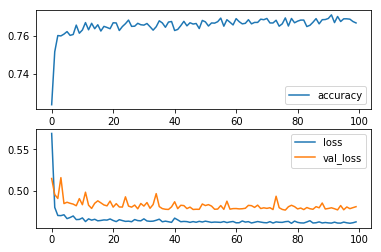

In [34]:
for layer in model.layers[:-3]:
    layer.trainable = False

for layer in model.layers[-3:]:
    layer.trainable = True
    
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(np.expand_dims(X_train_ptbdb, axis=2), 
                    y_train_ptbdb, 
                    validation_split=0.15,
                    epochs=100,
                    batch_size=128,
                    verbose=0)
plot_learning(history)

Even without the bottleneck, the results are pretty bad. Let's try one last time without bottleneck and with the whole model trainable.

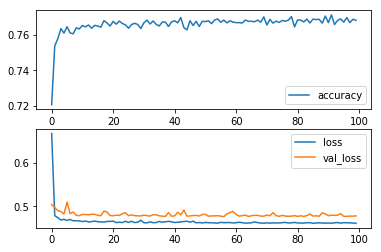

In [35]:
D1 = Dense(32)(model_mitbih.layers[-3].output)
D2 = Dense(32)(D1)
O = Dense(2, activation='softmax')(D2)
model = Model(inputs=model_mitbih.input, outputs=O)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(np.expand_dims(X_train_ptbdb, axis=2), 
                    y_train_ptbdb, 
                    validation_split=0.15,
                    epochs=100,
                    batch_size=128,
                    verbose=0)
plot_learning(history)

The model is converging at 76% accuracy, this is way below the 99% reached without transfer learning. I wonder how they managed to reach 95.6% accuracy with transfer learning in the article, and even though they did it would still be below the score reached without TL.